In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.feature_selection import RFECV

After importing our libraries, we read the CSV file containing information about solar power generated (MW) every 5 minutes for the whole year of 2006. We split the Date and Time information into new colums so we can later aggregate the total amount of power generated per day.

In [3]:
df = pd.read_csv('/Users/ayushpuri/Desktop/Solar/Actual_40.85_-73.85_2006_DPV_21MW_5_Min.csv')

df['LocalTime'] = pd.to_datetime(df['LocalTime']) 
df['Date'] = df['LocalTime'].dt.date
df['Time'] = df['LocalTime'].dt.time

print(df.head())

            LocalTime  Power(MW)        Date      Time
0 2006-01-01 00:00:00        0.0  2006-01-01  00:00:00
1 2006-01-01 00:05:00        0.0  2006-01-01  00:05:00
2 2006-01-01 00:10:00        0.0  2006-01-01  00:10:00
3 2006-01-01 00:15:00        0.0  2006-01-01  00:15:00
4 2006-01-01 00:20:00        0.0  2006-01-01  00:20:00


As shown in the preview, no power was generated around midnight on January 1, but for this analysis, we won't need 5-minute resolution. We'll want to take the sum of MW generated over each full day in the year, so we can later assign that total value as the dependent variable. We'll then correlate it to multiple independent variables, local weather features from a separate dataset.

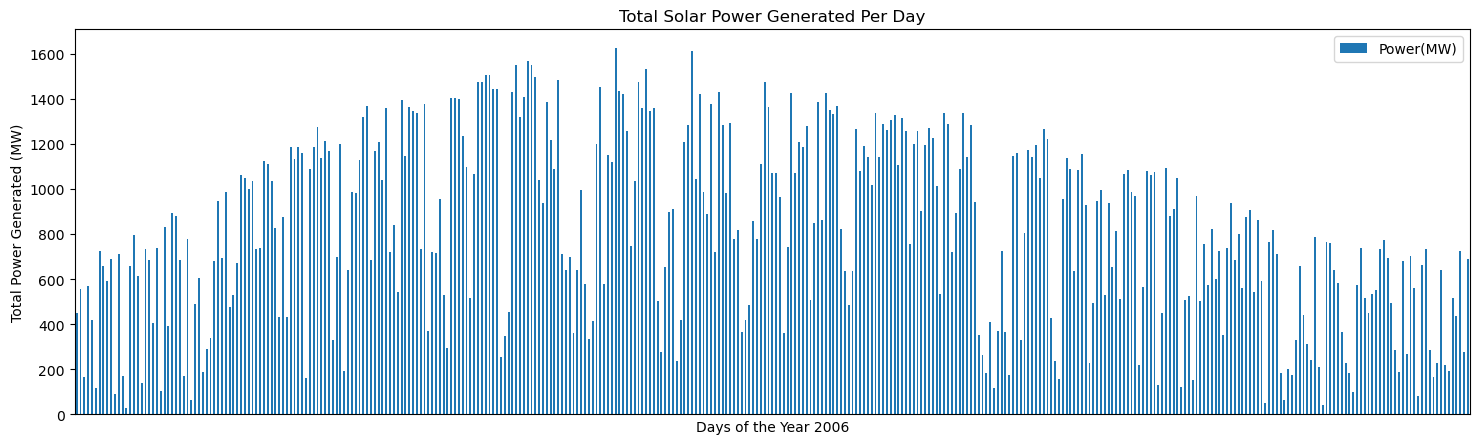

In [4]:
days_df = df.groupby('Date').sum('Power(MW)').reset_index()
days_df.plot(kind='bar', x='Date', y='Power(MW)', xlabel='Days of the Year 2006', ylabel='Total Power Generated (MW)')

plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().set_title('Total Solar Power Generated Per Day')
plt.gcf().set_size_inches(18, 5)


Above, we can see a sort of bell curve distribution among the high values, peaking in the summer months, with plenty of much lower days interspersed. To create a predictive model for total power generated per day, let's load up a separate CSV file containing key weather features for the corresponding time and place: the year 2006 in The Bronx, NY. 

In [5]:
features_df = pd.read_csv('/Users/ayushpuri/Desktop/Solar/Bronx_Weather_2006.csv', header=0)

print(features_df.head())


         Date  TempF       TempK  Humidity  HrsDaylight
0  2006-01-01   37.7  276.316667      75.2         9.00
1  2006-01-02   42.2  278.816667      73.7         9.04
2  2006-01-03   37.9  276.427778      85.2         9.08
3  2006-01-04   34.3  274.427778      70.4         9.12
4  2006-01-05   42.5  278.983333      76.5         9.16


Let's plot these 4 weather features throughout the year 2006 to get a visual sense of how they each vary over the year before completing the regression.

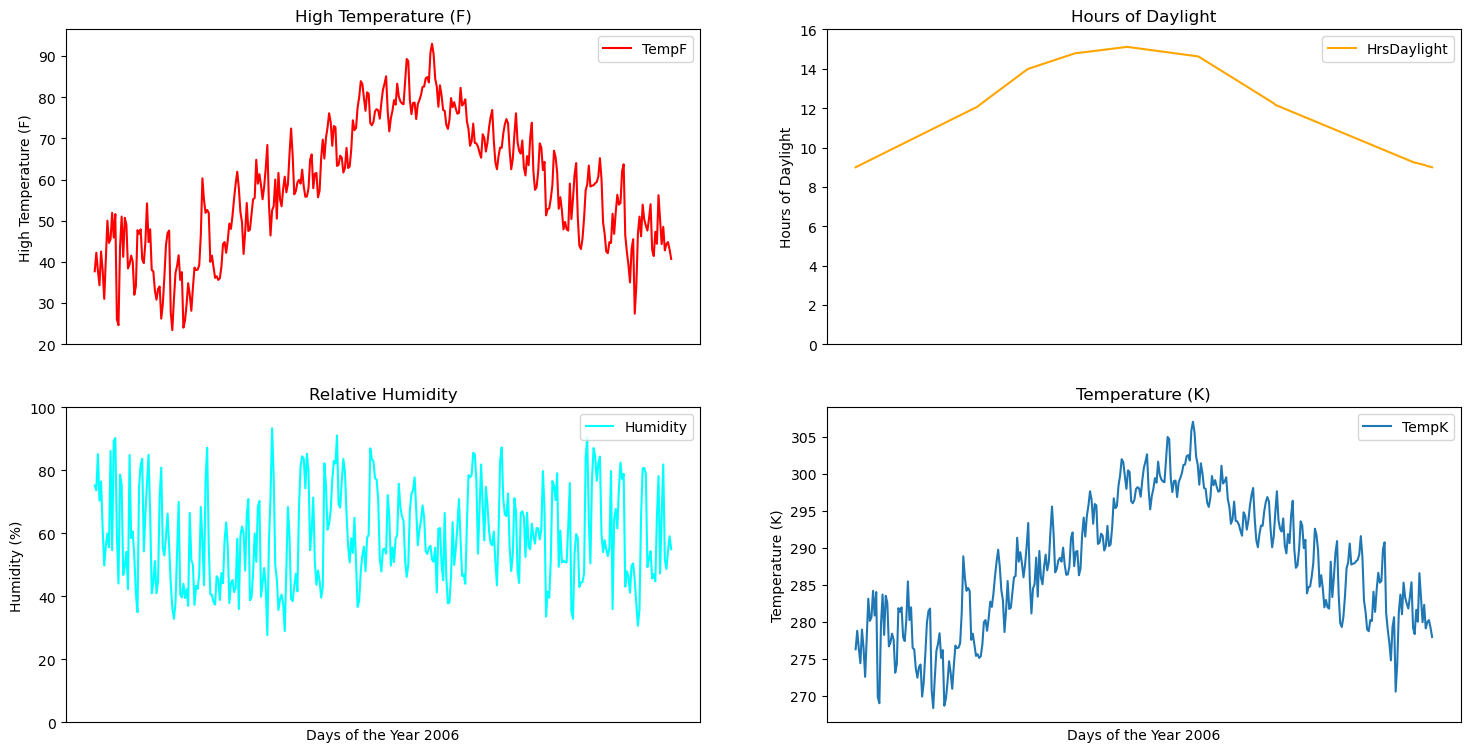

In [6]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 9))

features_df.plot(kind='line', x='Date', y='TempF', ax=axs[0, 0], color='red')
axs[0, 0].set_xlabel('')
axs[0, 0].set_ylabel('High Temperature (F)')
axs[0, 0].set_title('High Temperature (F)')
axs[0, 0].xaxis.set_major_locator(plt.NullLocator())

features_df.plot(kind='line', x='Date', y='HrsDaylight', ax=axs[0, 1], color='orange')
axs[0, 1].set_xlabel('')
axs[0, 1].set_ylabel('Hours of Daylight')
axs[0, 1].set_title('Hours of Daylight')
axs[0, 1].set_ylim(0, 16)
axs[0, 1].xaxis.set_major_locator(plt.NullLocator())

features_df.plot(kind='line', x='Date', y='Humidity', ax=axs[1, 0], color='cyan')
axs[1, 0].set_xlabel('Days of the Year 2006')
axs[1, 0].set_ylabel('Humidity (%)')
axs[1, 0].set_title('Relative Humidity')
axs[1, 0].set_ylim(0, 100)
axs[1, 0].legend(loc='upper right')
axs[1, 0].xaxis.set_major_locator(plt.NullLocator())

features_df.plot(kind='line', x='Date', y='TempK', ax=axs[1, 1])
axs[1, 1].set_xlabel('Days of the Year 2006')
axs[1, 1].set_ylabel('Temperature (K)')
axs[1, 1].set_title('Temperature (K)')
axs[1, 1].legend(loc='upper right')
axs[1, 1].xaxis.set_major_locator(plt.NullLocator())

Let's merge these two dataframes on Date (2006-01-01 to 2006-12-31) so we can draw our dependent and independent variables from the same place. Even though TempF (Fahrenheit) is not measured in an absolute unit like degrees Kelvin, linear regression is fortunately agnostic to scale and offset. (I even tried both with the same results!)

In [7]:
merge_df = days_df.merge(features_df,
                  on ='Date', how='right')
merge_df['Power(MW)'] = days_df['Power(MW)']

print(merge_df.head())

         Date  Power(MW)  TempF       TempK  Humidity  HrsDaylight
0  2006-01-01      451.3   37.7  276.316667      75.2         9.00
1  2006-01-02      557.7   42.2  278.816667      73.7         9.04
2  2006-01-03      164.7   37.9  276.427778      85.2         9.08
3  2006-01-04      567.5   34.3  274.427778      70.4         9.12
4  2006-01-05      418.6   42.5  278.983333      76.5         9.16


To train a linear regression model, we can now set the independent variables (X) as every column except Date and Power(MW), and set the dependent variable (y) to the column Power(MW) only. We can separate out a test set from our majority of training data to run predictions on later.

In [8]:
X = merge_df.drop('Power(MW)',axis=1)
X = X.drop('Date',axis=1)
y = merge_df['Power(MW)'].to_numpy().reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=40)

model = LinearRegression()
model.fit(X_train, y_train)

coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(model.coef_))], axis=1, ignore_index=True)
coefficients.rename(columns={0: 'Feature', 1: 'Coefficient'}, inplace=True)

print(coefficients)


       Feature   Coefficient
0        TempF  6.082121e+06
1        TempK -1.094782e+07
2     Humidity -1.655857e+01
3  HrsDaylight  1.016962e+02


As we might expect from these coefficients for each feature, TempF (high temperature in Fahrenheit) and HrsDaylight are positively correlated with the amount of solar power produced, while Humidity and TempK are negatively correlated. Now that training is complete, we can run predictions on the test set based on the weather conditions, then compare the model's predictions to the actual values in Difference and % Error.

In [9]:
predictions = model.predict(X_test)

predict_df = pd.DataFrame(y_test)
predict_df.columns = ['ActualValue(MW)']

predict_df['PredValue(MW)'] = predictions
predict_df['PredValue(MW)'] = predict_df['PredValue(MW)'].apply(lambda value:round(value, 1))

predict_df['Difference'] = predictions - y_test
predict_df['Difference'] = predict_df['Difference'].apply(lambda value:round(value, 1))

predict_df['% Error'] = round(100*(predict_df['Difference']/predict_df['ActualValue(MW)']), 2)

print(predict_df)
print('\n')
print('Mean Difference:')
print(round(predict_df['Difference'].sum()/36, 1))
print('\n')
print('Mean Squared Difference')
print(round(predict_df['Difference'].apply(lambda value:value**2).sum()/36, 1))

    ActualValue(MW)  PredValue(MW)  Difference  % Error
0            1286.4         1066.1      -220.3   -17.13
1             881.9         1007.7       125.8    14.26
2             812.3          881.2        68.9     8.48
3             994.3          634.3      -360.0   -36.21
4             494.2          676.7       182.5    36.93
5             689.9          552.9      -137.0   -19.86
6             367.5          641.4       273.9    74.53
7            1198.4         1006.5      -191.9   -16.01
8             860.4          834.1       -26.3    -3.06
9            1435.2         1296.3      -138.9    -9.68
10           1186.6          851.8      -334.8   -28.22
11           1185.0         1101.5       -83.5    -7.05
12           1186.9          916.9      -270.0   -22.75
13            185.5          159.7       -25.8   -13.91
14            786.8          682.4      -104.4   -13.27
15            116.0          500.7       384.7   331.64
16            567.5          273.8      -293.7  

The negative Mean Difference value observed indicates that this linear regression model generally tends to underestimate how much solar power will be generated, while the Mean Squared Difference provides a metric for evaluating the total error. 

Let's merge the Date column back into our predictions and visualize the model's overall performance on the random sample of test data. Not bad at all, considering these solar predictions are exclusively based on weather data!

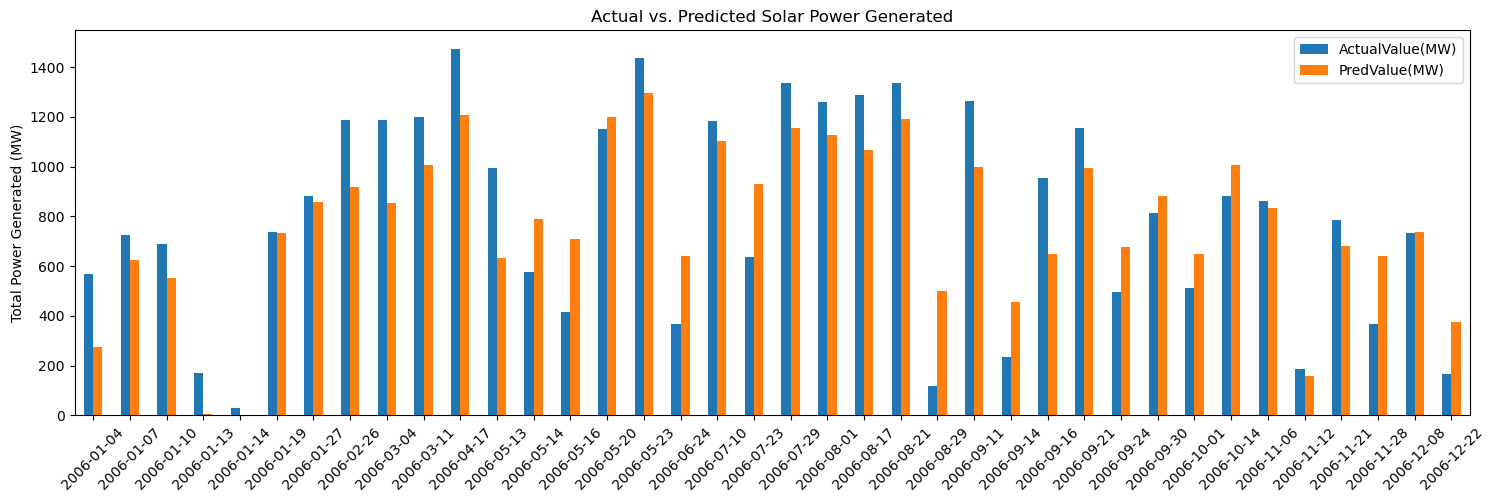

In [10]:
merge_test_df = predict_df.merge(merge_df,
                  left_on='ActualValue(MW)', right_on='Power(MW)', how='left')
merge_test_df.sort_values(by=['Date'], inplace=True)
merge_test_df = merge_test_df.reset_index(drop=True)

merge_test_df.plot(x='Date', y=['ActualValue(MW)', 'PredValue(MW)'], xlabel='', ylabel='Total Power Generated (MW)', kind="bar", rot=45)
plt.gca().set_title('Actual vs. Predicted Solar Power Generated')
plt.gcf().set_size_inches(18, 5)

Visually, the trend in bias is more evident, with predictions often erring towards the middle: dates with high solar power generated are particularly susceptible to underestimating, while days with very low solar power generated may be overestimated.

However, could any of the weather features we included actually be detrimental to the model's accuracy? Let's use a recursive feature elimination with cross-validation to tell us the optimal combination of weather features.

In [11]:
X = merge_df.drop('Power(MW)',axis=1)
X = X.drop('Date',axis=1)
y = merge_df['Power(MW)']

estimator = SVR(kernel='linear')
rfecv = RFECV(estimator, step=1, cv=5)
rfecv.fit(X, y)

features = list(X.columns[rfecv.support_])
print('Optimal number of features: ', rfecv.n_features_)
print(features)

Optimal number of features:  2
['Humidity', 'HrsDaylight']


Sure enough, the TempF feature is actually causing the model to perform sub-optimally! Let's drop it entirely then repeat the same training and testing procedure.

In [12]:
X_2 = X.drop('TempF',axis=1)
y_2 = merge_df['Power(MW)']

X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(
    X_2, y_2, test_size=0.1, random_state=40)

model_2 = LinearRegression()
model_2.fit(X_2_train, y_2_train)

coefficients_2 = pd.concat([pd.DataFrame(X_2.columns),pd.DataFrame(np.transpose(model_2.coef_))], axis=1, ignore_index=True)
coefficients_2.rename(columns={0: 'Feature', 1: 'Coefficient'}, inplace=True)

print(coefficients_2)

       Feature  Coefficient
0        TempK     1.637553
1     Humidity   -16.559815
2  HrsDaylight   101.688731


In [13]:
predictions_2 = model_2.predict(X_2_test)

predict_df_2 = pd.DataFrame(y_2_test)
predict_df_2.columns = ['ActualValue(MW)']

predict_df_2['PredValue(MW)'] = predictions_2
predict_df_2['PredValue(MW)'] = predict_df_2['PredValue(MW)'].apply(lambda value:round(value, 1))

predict_df_2['Difference'] = predictions_2 - y_2_test
predict_df_2['Difference'] = predict_df_2['Difference'].apply(lambda value:round(value, 1))

predict_df_2['% Error'] = round(100*(predict_df_2['Difference']/predict_df_2['ActualValue(MW)']), 2)

print(predict_df_2)
print('\n')
print('Mean Difference:')
print(round(predict_df_2['Difference'].sum()/36, 1))
print('\n')
print('Mean Squared Difference')
print(round(predict_df_2['Difference'].apply(lambda value:value**2).sum()/36, 1))

     ActualValue(MW)  PredValue(MW)  Difference  % Error
228           1286.4         1066.1      -220.3   -17.13
286            881.9         1008.2       126.3    14.32
272            812.3          881.1        68.8     8.47
132            994.3          634.2      -360.1   -36.22
266            494.2          676.7       182.5    36.93
9              689.9          552.9      -137.0   -19.86
174            367.5          641.8       274.3    74.64
69            1198.4         1006.8      -191.6   -15.99
309            860.4          833.7       -26.7    -3.10
142           1435.2         1296.8      -138.4    -9.64
62            1186.6          851.3      -335.3   -28.26
190           1185.0         1101.9       -83.1    -7.01
56            1186.9          917.4      -269.5   -22.71
315            185.5          159.9       -25.6   -13.80
324            786.8          682.3      -104.5   -13.28
240            116.0          500.7       384.7   331.64
3              567.5          2

After removing the TempF feature, the Mean Difference is only very slightly smaller, but the Mean Squared Difference is  very slightly Smaller. 



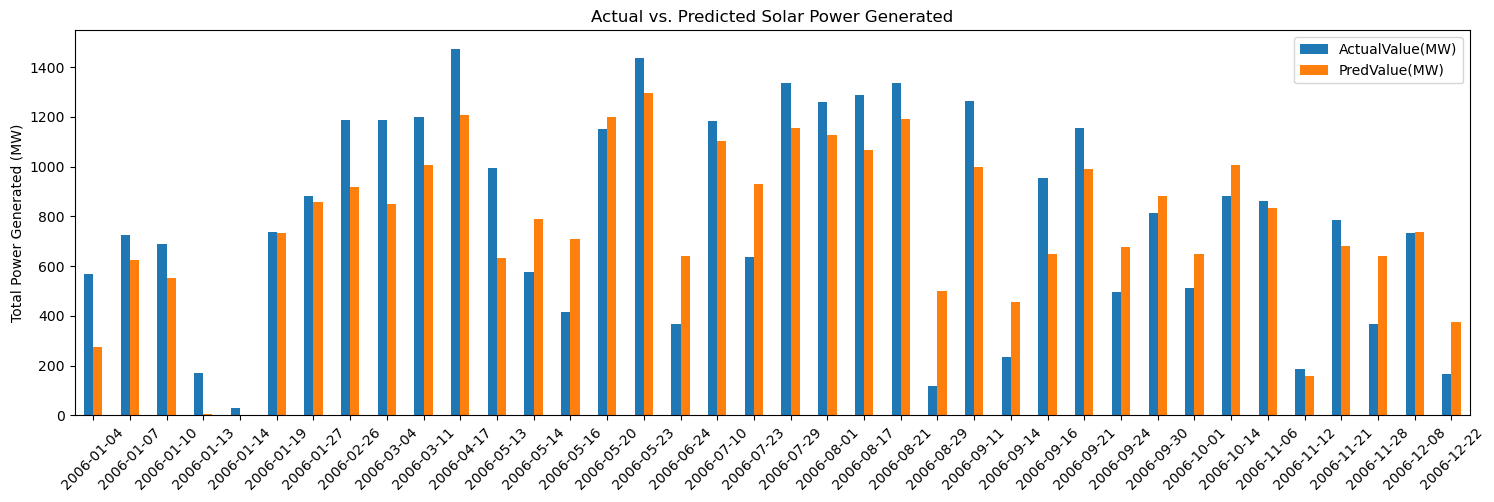

In [14]:
merge_test_df_2 = predict_df_2.merge(merge_df,
                  left_on='ActualValue(MW)', right_on='Power(MW)', how='left')
merge_test_df_2.sort_values(by=['Date'], inplace=True)
merge_test_df_2 = merge_test_df_2.reset_index(drop=True)

merge_test_df_2.plot(x='Date', y=['ActualValue(MW)', 'PredValue(MW)'], xlabel='', ylabel='Total Power Generated (MW)', kind="bar", rot=45)
plt.gca().set_title('Actual vs. Predicted Solar Power Generated')
plt.gcf().set_size_inches(18, 5)

As we can see, the predicted results are very close to what we had before. Since the High Temperature (Fahrenheit) feature doesn't seem to be adding significant value, we'll do without it, achieving these results.